Step 1: Import library

In [12]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

Step 2: Reading data and processing

In [13]:

df = pd.read_csv("household.csv")

df = df.drop([
    'main', 'description', 'temp_min', 'temp_max', 'temp_t+1',
    'feels_like_t+1', 'deg', 'current', 'voltage', 'reactive_power',
    'apparent_power', 'power_factor'
], axis=1)


df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# Resample the data from minute-level to hourly averages (H)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)

/tmp/ipython-input-1119042937.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


In [14]:
df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()

# Drop rows with NaN values created by the shift/rolling operations
df_hour.dropna(inplace=True)

Step 3: Preparing data and Training model

In [15]:

target_feature = 'active_power'

features = [col for col in df_hour.columns if col not in ['date', target_feature]]

X = df_hour[features]
y = df_hour[target_feature]

# Calculate the size of the training set (80% of data)
train_size = int(len(df_hour) * 0.8)
# Split data based on time order (critical for time series)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training size: {len(X_train)} | Testing size: {len(X_test)}")

# Initialize the XGBoost Regressor model
xgb_model = XGBRegressor(
    objective='reg:squarederror', # Loss function for regression tasks
    n_estimators=100,             # Number of boosting rounds (trees)
    learning_rate=0.1,            # Step size shrinkage to prevent overfitting
    max_depth=5,                  # Maximum depth of each tree
    random_state=42
)

# Train the model using the training data
xgb_model.fit(X_train, y_train)

Training size: 8089 | Testing size: 2023


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Step 4:  PREDICTION AND EVALUATION

--- XGBoost Regression Performance: ---
MAE : 56.66
RMSE : 74.94
R-squared (R2 Score): 0.3987
MAPE: 31.064%

--- Top 5 Feature Importance ---
ap_lag_1h      0.483440
ap_roll_24h    0.355554
feels_like     0.030691
ap_lag_24h     0.026915
speed          0.022683
dtype: float32


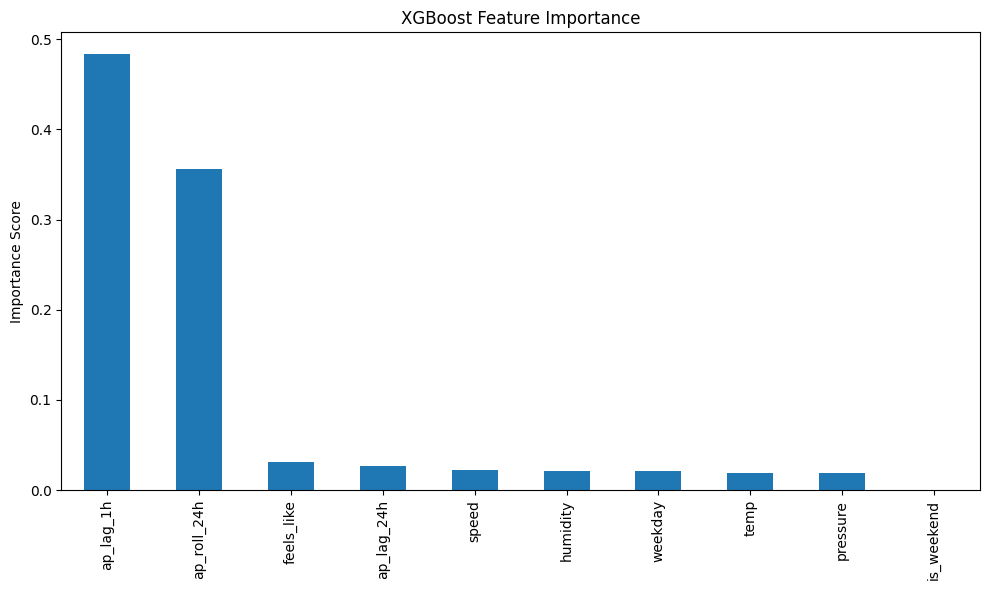

In [16]:

y_pred_xgb = xgb_model.predict(X_test)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Calculate performance metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"--- XGBoost Regression Performance: ---")
print(f"MAE : {mae_xgb:.2f}")
print(f"RMSE : {rmse_xgb:.2f}")
print(f"R-squared (R2 Score): {r2_xgb:.4f}")
print(f'MAPE: {mape:.3f}%')


feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- Top 5 Feature Importance ---")
print(feature_importances.head())

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()